In [281]:
import os, json, pprint, pickle, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l1, l2
import matplotlib.pyplot as plt
root_data = "/data/cm/"
root = "/home/rovera/cm/"
chars_blacklist = set(["ו", "י", "ם", "מ", "д", "ן", "ע", "ש", "ת", "л", "н", "т", 'б', 'ר', '״', '־', '׳'])

In [275]:
def count_word_len(pairs):
    word_len = {}
    for pair in pairs:
        if " " not in pair[1]:
            if len(pair[1]) not in word_len:
                word_len[len(pair[1])] = 0
            word_len[len(pair[1])] += 1
    return word_len

def extract_words_by_len(pairs, word_len_dict):
    random.shuffle(pairs)
    out_word_pairs = []
    for length, count in word_len_dict.items():
        counter = 0
        for i in range(len(pairs)):
            if len(pairs[i][0]) == length:
                out_word_pairs.append(pairs[i])
                counter += 1
            if counter == count:
                break
    return out_word_pairs

In [282]:
# get the data and prepare
wrong, oov, correct = [], [], []
wrong = pickle.load(open(root_data+"data/ocr_correction/training_data/wrong.pickle", "rb"))
oov = pickle.load(open(root_data+"data/ocr_correction/training_data/oov_correct.pickle", "rb"))
correct = pickle.load(open(root_data+"data/ocr_correction/training_data/correct.pickle", "rb"))
random.shuffle(correct)
#correct = correct[:6100]

word_len = count_word_len(wrong)
correct_train = extract_words_by_len(correct, word_len)

In [283]:
data = list(set(wrong + oov + correct_train))

In [284]:
data_ger = []
for pair in data:
    is_in_black = False
    for char in pair[0]:
        if char in chars_blacklist:
            is_in_black = True
            break
    for char in pair[1]:
        if char in chars_blacklist:
            is_in_black = True
            break
    if is_in_black is False:
        data_ger.append(pair)

In [285]:
data = data_ger
random.shuffle(data)
print(len(data))

14678


In [261]:
for d in data[:50]:
    print(d)

('Angelegenst', 'Angelegenheit')
('Damenund', 'Damen- und')
('Lckweste', 'Schwester')
('Grobgemeinde', 'Großgemeinde')
("des'Friedens", 'des Friedens')
('ledach', 'jedoch')
('Geburtsund', 'Geburts- und')
('Mtnchaund', 'Mincha- und')
('^crlmudS', 'Talmud')
('Cömmentar', 'Commentar')
('Borarhetien', 'Vorarbeiten')
('südischcr', 'jüdischer')
('lybischrn', 'lybischen')
('Oesterreichets', 'Oesterreichers')
('Kecensioiien', 'Recensionen')
('Tbaisachc', 'Thatsache')
('CulturInterejsen', 'Cultur-Interessen')
('.genanntes', 'genanntes')
('Konfeveuz', 'Konferenz')
('ftlbst', 'selbst')
('.Mltusgesctz', 'Kultusgesetz')
('Fonsera', 'Fonseca')
('nnS', 'uns')
('zusamnicnlicfen', 'zusammenliefen')
('behändigcn', 'behändigen')
('PantnS', 'Paulus')
('Bermögensverhältnissen', 'Vermögensverhältnissen')
('Geistesund', 'Geistes- und')
('Ltossgebiete', 'Stoffgebiete')
('längsx', 'länger')
('Füste', 'Füsse')
('Hoftat', 'Hofrat')
('versiehe', 'verstehe')
('lrvjährigem', '50jährigem')
('MmrgeüDelMvtz', 'Morgenz

In [286]:
# Prepare the data
input_words = []
target_words = []
input_chars = set([])
target_chars = set(["\t", "\n"])

for pair in data:
    input_words.append(list(pair[0]))
    target_words.append(list("\t"+pair[1]+"\n"))
    
    for char in pair[0]:
        input_chars.add(char)
        
    for char in pair[1]:
        target_chars.add(char)
        
input_chars = sorted(list(input_chars))
target_chars = sorted(list(target_chars))
num_encoder_chars = len(input_chars)
num_decoder_chars = len(target_chars)
max_encoder_seq_length = max([len(word) for word in input_words])
max_decoder_seq_length = max([len(word) for word in target_words])

print("Number of samples:", len(input_words))
print("Number of unique input chars:", num_encoder_chars)
print("Number of unique output chars:", num_decoder_chars)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 14678
Number of unique input chars: 108
Number of unique output chars: 96
Max sequence length for inputs: 38
Max sequence length for outputs: 48


In [287]:
input_chars_index = dict([(char, i) for i, char in enumerate(input_chars)])
target_chars_index = dict([(char, i) for i, char in enumerate(target_chars)])

In [288]:
encoder_input_data = np.zeros((len(input_words), max_encoder_seq_length, num_encoder_chars), dtype="float32")
decoder_input_data = np.zeros((len(input_words), max_decoder_seq_length, num_decoder_chars), dtype="float32")
decoder_target_data = np.zeros((len(input_words), max_decoder_seq_length, num_decoder_chars), dtype="float32")

In [265]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(6580, 38, 101)
(6580, 48, 90)
(6580, 48, 90)


In [289]:
for i, (input_word, target_word) in enumerate(zip(input_words, target_words)):
    for t, char in enumerate(input_word):
        encoder_input_data[i, t, input_chars_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_chars_index[" "]] = 1.0
    for t, char in enumerate(target_word):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_chars_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_chars_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_chars_index[" "]] = 1.0
    decoder_target_data[i, t:, target_chars_index[" "]] = 1.0

In [290]:
latent_dim = 256

In [291]:
# BUILD THE MODEL
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_chars))
encoder = keras.layers.Bidirectional(keras.layers.LSTM(latent_dim, return_state=True, recurrent_dropout=0.4, dropout=0.5))
encoder_outputs, state_h_for, state_c_for, state_h_back, state_c_back = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
state_h = keras.layers.Concatenate()([state_h_for, state_h_back])
state_c = keras.layers.Concatenate()([state_c_for, state_c_back])

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_chars))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(2*latent_dim, return_sequences=True, return_state=True, recurrent_dropout=0.4, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_chars, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [292]:
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=16,
    epochs=100,
    validation_split=0.2
)


# Save model
model.save("wrong2correct")

Epoch 1/100
734/734 [==============================] - 323s 439ms/step - loss: 0.7339 - accuracy: 0.8084 - val_loss: 0.5746 - val_accuracy: 0.8427
Epoch 2/100
734/734 [==============================] - 322s 438ms/step - loss: 0.5486 - accuracy: 0.8480 - val_loss: 0.4197 - val_accuracy: 0.8841
Epoch 3/100
667/734 [==========================>...] - ETA: 28s - loss: 0.4721 - accuracy: 0.8678

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


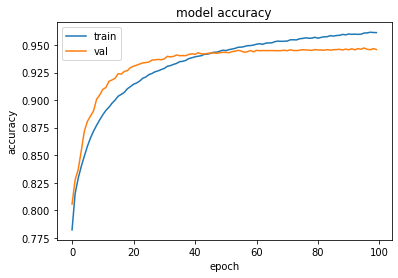

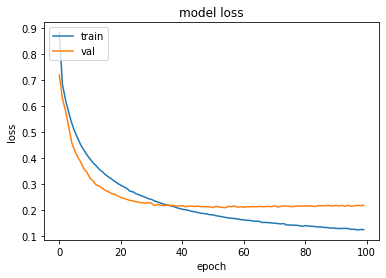

In [270]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [271]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("wrong2correct")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc_for, state_c_enc_for, state_h_enc_back, state_c_enc_back = model.layers[1].output  # lstm_1
encoder_states = [keras.layers.Concatenate()([state_h_enc_for, state_h_enc_back]), 
                  keras.layers.Concatenate()([state_c_enc_for, state_c_enc_back])]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(2*latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(2*latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[5]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[6]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_chars_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_chars_index.items())

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_chars))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_chars_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_chars))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [272]:
for seq_index in range(60, 120):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_word = decode_sequence(input_seq)
    print("-")
    print("Input word:", "".join(input_words[seq_index]))
    print("Decoded word:", decoded_word)


-
Input word: Sprachaebrauche
Decoded word: Sprachgebrauche

-
Input word: Knltusgemeinde
Decoded word: Kultusgemeinde

-
Input word: WormS
Decoded word: Worms

-
Input word: aitsgeht
Decoded word: ausgeht

-
Input word: GcrnchSorgan
Decoded word: Geruchsorgan

-
Input word: Oschamnrrgebct
Decoded word: Oschamnagebet

-
Input word: ineinis
Decoded word: in einigen

-
Input word: siestgefttzr
Decoded word: festgesetzt

-
Input word: Geburtstages'<(rwjeseni-a
Decoded word: Geburtstages gewiesenen

-
Input word: anznstehödtN
Decoded word: anzustehend

-
Input word: Verwundüngen
Decoded word: Verwundungen

-
Input word: sollm
Decoded word: sollen

-
Input word: ahgefaßt
Decoded word: abgefaßt

-
Input word: Reimgungswasser
Decoded word: Reinigungswasser

-
Input word: hinaus'in
Decoded word: hinaus in

-
Input word: Angleichunig
Decoded word: Angleichung

-
Input word: Mnjikdiktat
Decoded word: Musikdiktat

-
Input word: rieh
Decoded word: nich

-
Input word: Rcgierung
Decoded word: Regier